# Chess Opening Classification Project

This project aims to classify the most likely chess openings from a given board position in FEN notation. The model will take a chess board state as input and output the top 5 most probable openings that could have led to that position.

The dataset used for this project was 2,000,000 randomly extracted board states from this 6,000,000 chess game dataset. For more information regarding how the boards were extracted from this dataset, see the /data/preprocessing/ directory of this project. 

https://www.kaggle.com/datasets/arevel/chess-games


### Imports

In [37]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import chess
import chess.svg
from IPython.display import SVG, display

## Data Loading and Setup

In [38]:
# Load the data
df = pl.read_csv('data/chess_boards_sample.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("\nColumns:", df.columns)
print("\nFirst few rows:")
display(df.head())

Dataset shape: (2114769, 4)

Columns: ['ECO', 'Opening', 'Position', 'MoveNumber']

First few rows:


ECO,Opening,Position,MoveNumber
str,str,str,i64
"""B90""","""Sicilian Defense: Najdorf, Lip…","""rnbqkbnr/pp1ppppp/8/2p5/4P3/5N…",3
"""D02""","""Queen's Pawn Game: London Syst…","""2R1r1k1/4rpp1/p7/1pQp2q1/5P1p/…",63
"""C36""","""King's Gambit Accepted, Modern…","""rnbqkbnr/ppp2ppp/8/3p4/4Pp2/5N…",6
"""B01""","""Scandinavian Defense: Mieses-K…","""rn2kb1r/pppbpppp/1q3n2/8/2PP4/…",12
"""C62""","""Ruy Lopez: Steinitz Defense""","""1r3rk1/5pp1/3p3p/2pRb3/4P3/2P2…",43


### Field explanations

- ECO: The Encyclopaedia of Chess Openings code for the opening
- Opening: The name of the chess opening
- Position: The chess position in FEN (Forsyth–Edwards Notation) format
- MoveNumber: The move number in the game where this position occurred

In [39]:
# Check for missing values
print("Missing values in each column should be none due to pre-processing done")
display(df.null_count())

Missing values in each column should be none due to pre-processing done


ECO,Opening,Position,MoveNumber
u32,u32,u32,u32
0,0,0,0


## Exploratory Data Analysis (EDA)

Let's analyze our dataset to understand:
1. Distribution of openings
2. Move numbers where positions occur
3. ECO code distribution
4. Distribution of number of turns for the boards in our dataset

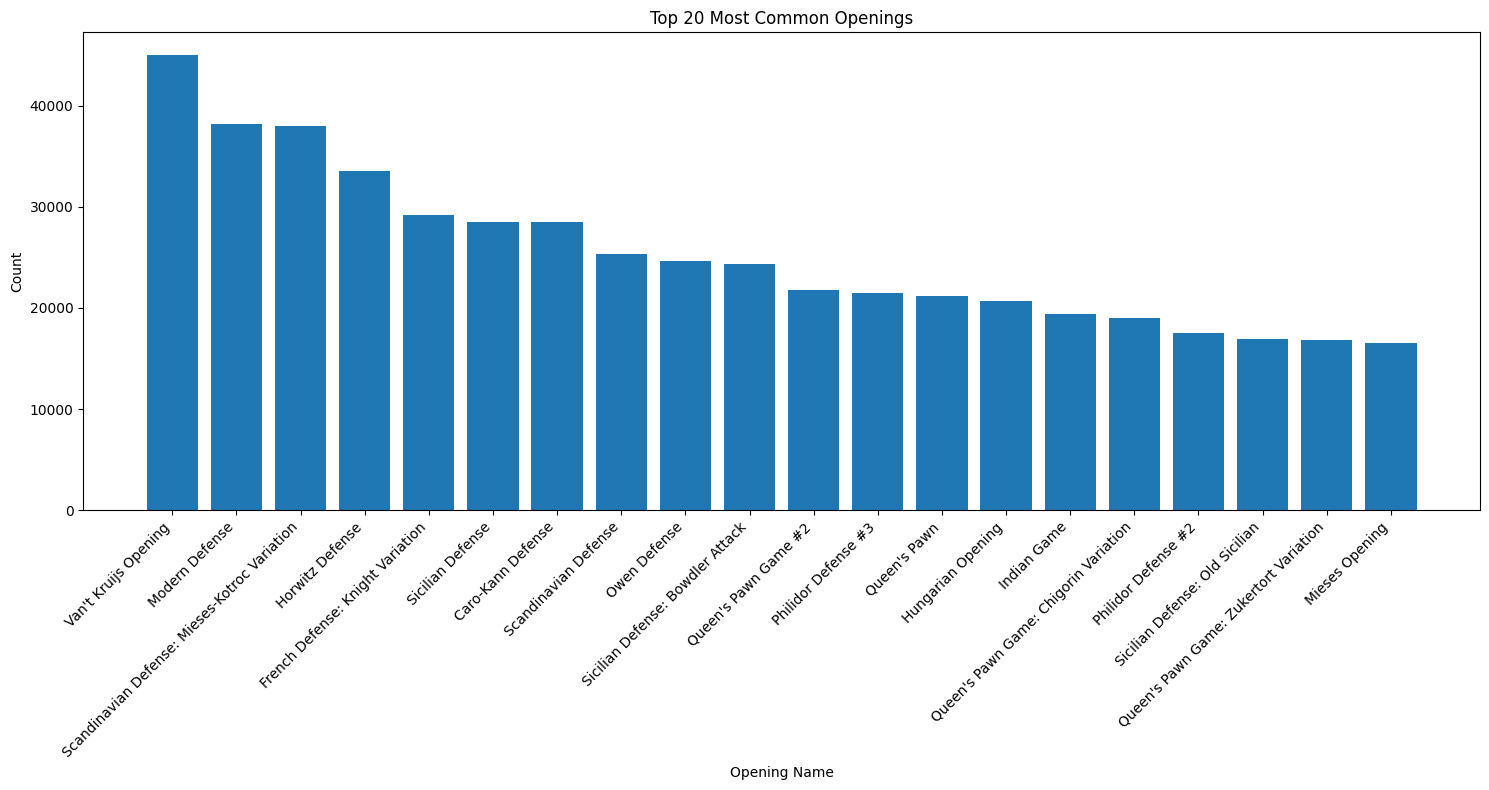

In [40]:
# Opening distribution
plt.figure(figsize=(15, 8))

# Get opening counts
opening_counts = (df
    .group_by('Opening')
    .agg(pl.len().alias('count'))
    .sort('count', descending=True)
    .head(20)
)

plt.bar(range(len(opening_counts)), opening_counts.select('count').to_series())
plt.xticks(range(len(opening_counts)), opening_counts.select('Opening').to_series(), rotation=45, ha='right')
plt.title('Top 20 Most Common Openings')
plt.xlabel('Opening Name')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Looking at the most common chess openings in our dataset, we see Van't Kruijs Opening occurs much more frequently than others, making up a large portion of our data. This is followed by various popular defenses like Modern Defense and Sicilian variations.

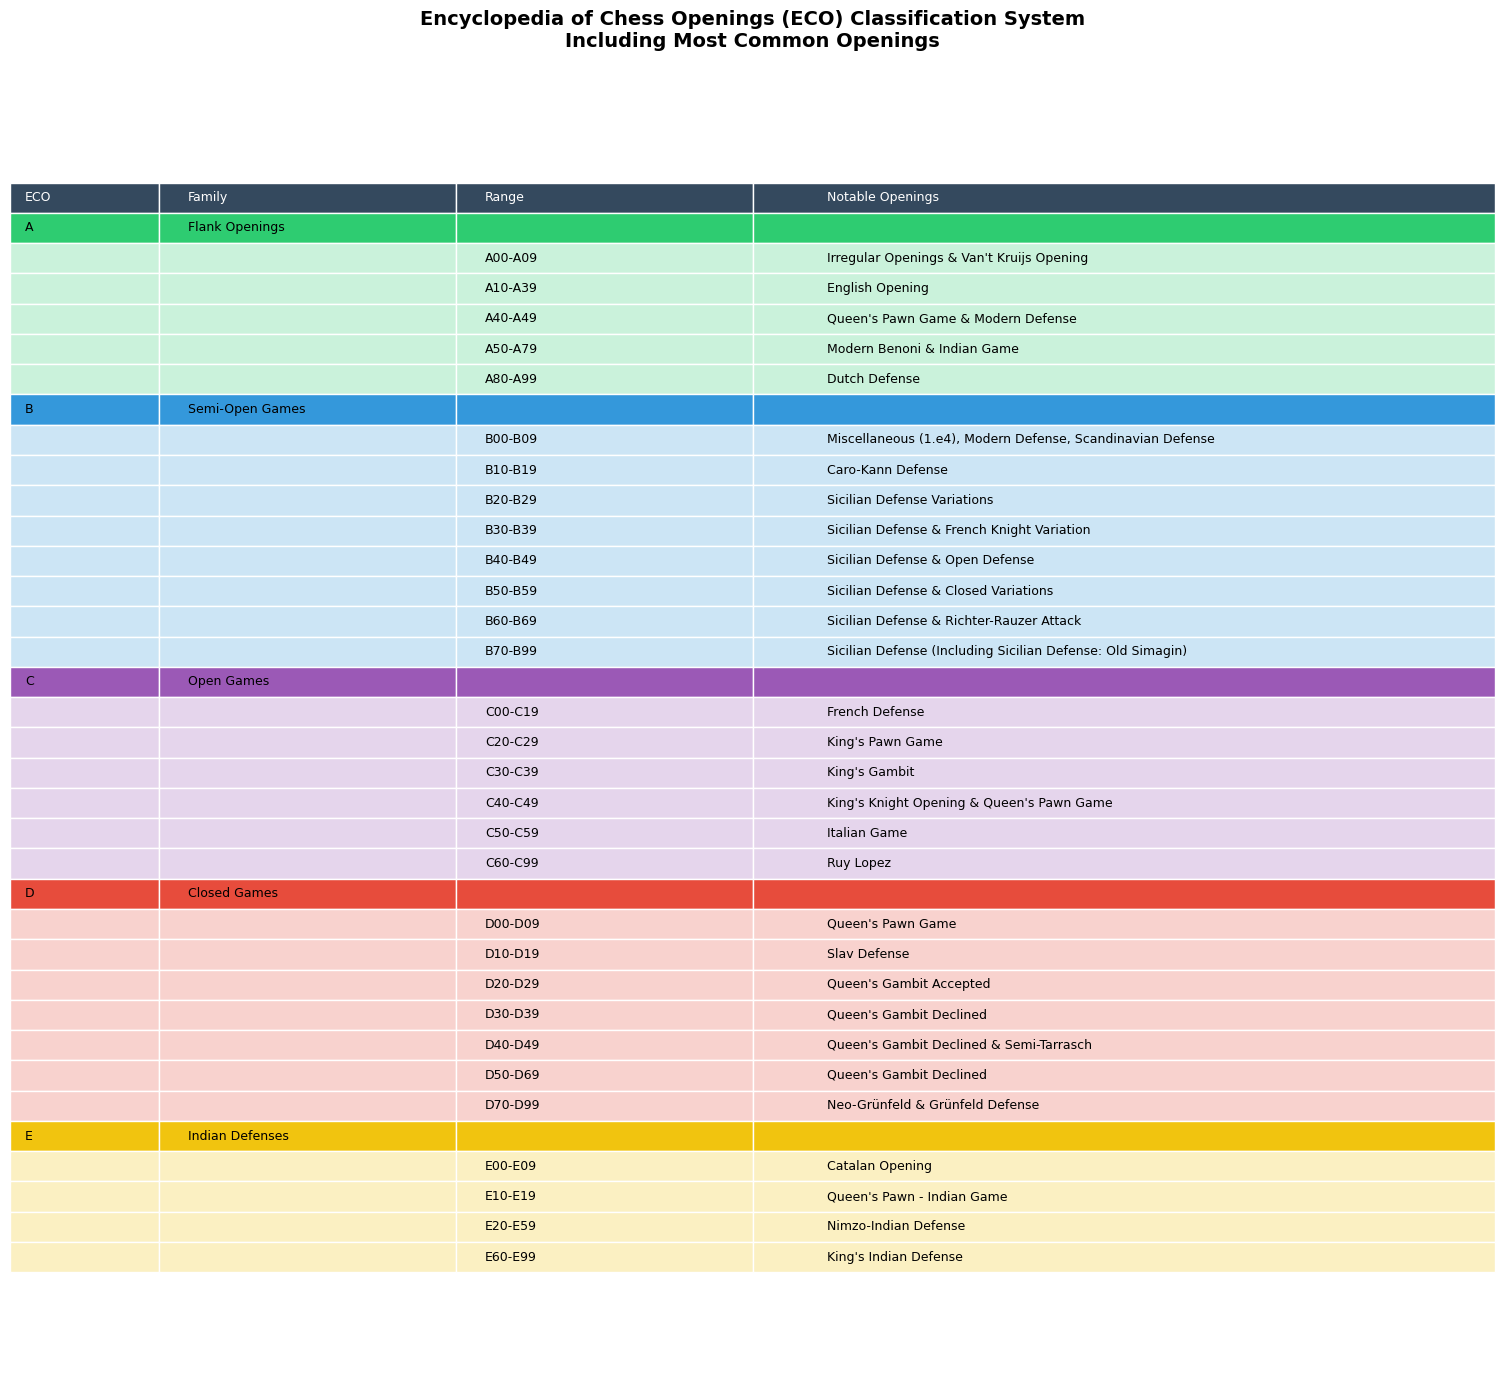

In [41]:
def create_eco_legend():
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(15, 14))  # Made taller to accommodate more entries
    ax.set_axis_off()

    # Color mapping for each ECO letter
    colors = {
        'A': '#2ecc71',  # Green
        'B': '#3498db',  # Blue
        'C': '#9b59b6',  # Purple
        'D': '#e74c3c',  # Red
        'E': '#f1c40f'   # Yellow
    }

    # Create data for the table
    table_data = []
    cell_colors = []
    
    eco_sections = {
        'A': ('Flank Openings', {
            'A00-A09': 'Irregular Openings & Van\'t Kruijs Opening',
            'A10-A39': 'English Opening',
            'A40-A49': "Queen's Pawn Game & Modern Defense",
            'A50-A79': 'Modern Benoni & Indian Game',
            'A80-A99': 'Dutch Defense'
        }),
        'B': ('Semi-Open Games', {
            'B00-B09': 'Miscellaneous (1.e4), Modern Defense, Scandinavian Defense',
            'B10-B19': 'Caro-Kann Defense',
            'B20-B29': 'Sicilian Defense Variations',
            'B30-B39': 'Sicilian Defense & French Knight Variation',
            'B40-B49': 'Sicilian Defense & Open Defense',
            'B50-B59': 'Sicilian Defense & Closed Variations',
            'B60-B69': 'Sicilian Defense & Richter-Rauzer Attack',
            'B70-B99': 'Sicilian Defense (Including Sicilian Defense: Old Simagin)'
        }),
        'C': ('Open Games', {
            'C00-C19': 'French Defense',
            'C20-C29': "King's Pawn Game",
            'C30-C39': "King's Gambit",
            'C40-C49': "King's Knight Opening & Queen's Pawn Game",
            'C50-C59': 'Italian Game',
            'C60-C99': 'Ruy Lopez'
        }),
        'D': ('Closed Games', {
            'D00-D09': "Queen's Pawn Game",
            'D10-D19': 'Slav Defense',
            'D20-D29': "Queen's Gambit Accepted",
            'D30-D39': "Queen's Gambit Declined",
            'D40-D49': "Queen's Gambit Declined & Semi-Tarrasch",
            'D50-D69': "Queen's Gambit Declined",
            'D70-D99': 'Neo-Grünfeld & Grünfeld Defense'
        }),
        'E': ('Indian Defenses', {
            'E00-E09': 'Catalan Opening',
            'E10-E19': "Queen's Pawn - Indian Game",
            'E20-E59': 'Nimzo-Indian Defense',
            'E60-E99': "King's Indian Defense"
        })
    }

    # Add header
    table_data.append(['ECO', 'Family', 'Range', 'Notable Openings'])
    cell_colors.append(['#34495e'] * 4)  # Dark header color

    # Fill data
    for eco_letter, (family_name, ranges) in eco_sections.items():
        # Add family header
        table_data.append([eco_letter, family_name, '', ''])
        cell_colors.append([colors[eco_letter]] * 4)
        
        # Add ranges
        for range_code, description in ranges.items():
            table_data.append(['', '', range_code, description])
            cell_colors.append([colors[eco_letter] + '40'] * 4)  # 40 is for opacity

    # Create table
    table = ax.table(
        cellText=table_data,
        cellColours=cell_colors,
        cellLoc='left',
        loc='center',
        colWidths=[0.1, 0.2, 0.2, 0.5]
    )

    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)

    # Customize cell appearance
    for cell in table._cells.values():
        cell.set_text_props(color='white' if cell.get_facecolor()[:3] == (52/255, 73/255, 94/255) else 'black')
        cell.set_edgecolor('white')
        cell.set_text_props(wrap=True)

    plt.title('Encyclopedia of Chess Openings (ECO) Classification System\nIncluding Most Common Openings', 
              pad=20, size=14, weight='bold')
    
    plt.tight_layout()
    plt.show()

# Create the visualization
create_eco_legend()

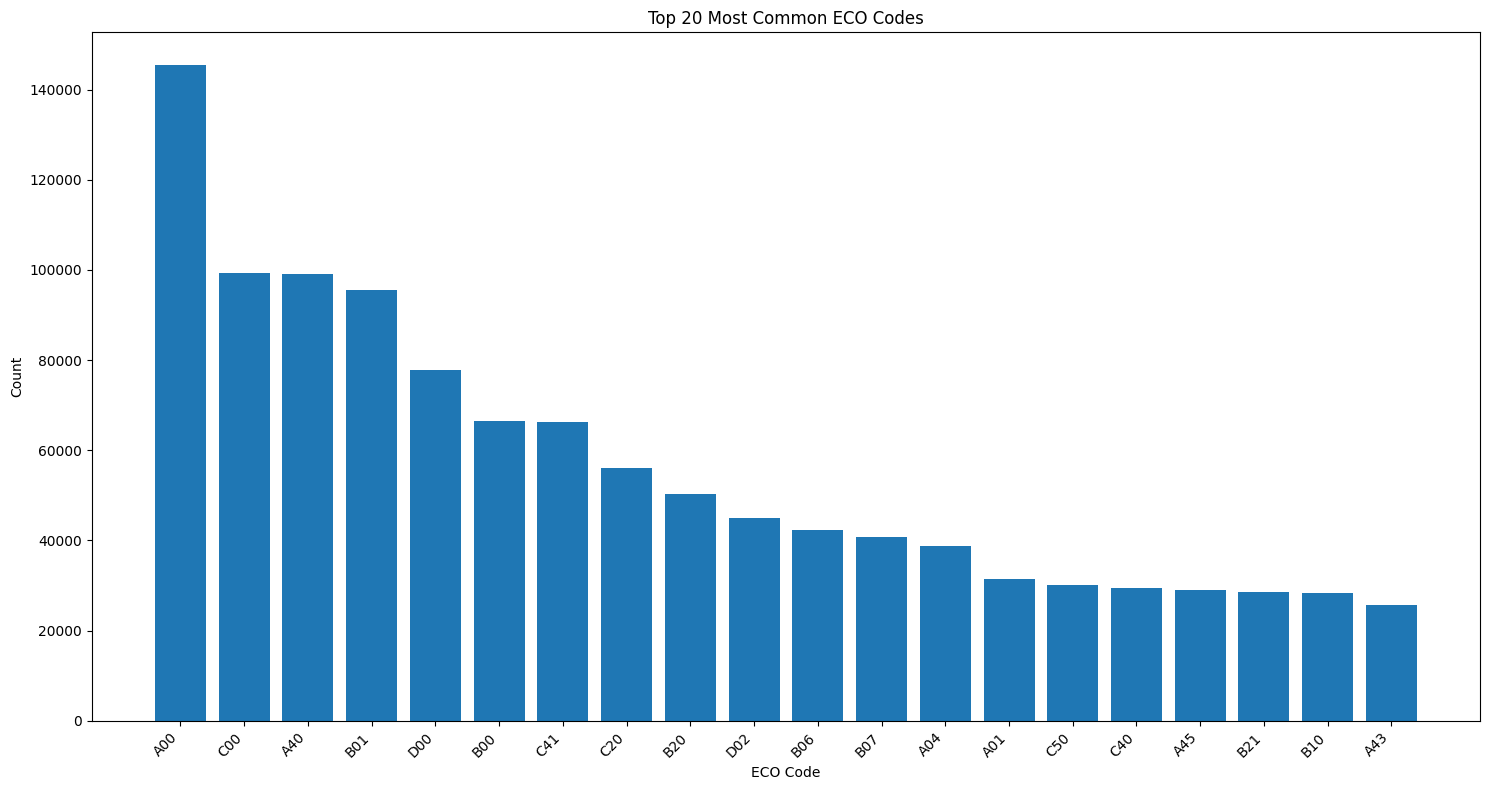

In [42]:
# ECO code distribution on a new figure
plt.figure(figsize=(15, 8))
eco_counts = (df
    .group_by('ECO')
    .agg(pl.len().alias('count'))
    .sort('count', descending=True)
    .head(20)
)
plt.bar(range(len(eco_counts)), eco_counts.select('count').to_series())
plt.xticks(range(len(eco_counts)), eco_counts.select('ECO').to_series(), rotation=45, ha='right')
plt.title('Top 20 Most Common ECO Codes')
plt.xlabel('ECO Code')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

The distribution of ECO (Encyclopedia of Chess Openings) codes shows A00 as the most frequent code by a large margin, which aligns with our earlier finding about Van't Kruijs Opening's dominance. There's a clear step-down pattern through the remaining codes, spread across different opening families (A, B, C, D, and E series), suggesting our dataset covers a wide range of opening systems but with some imbalance in their representation.

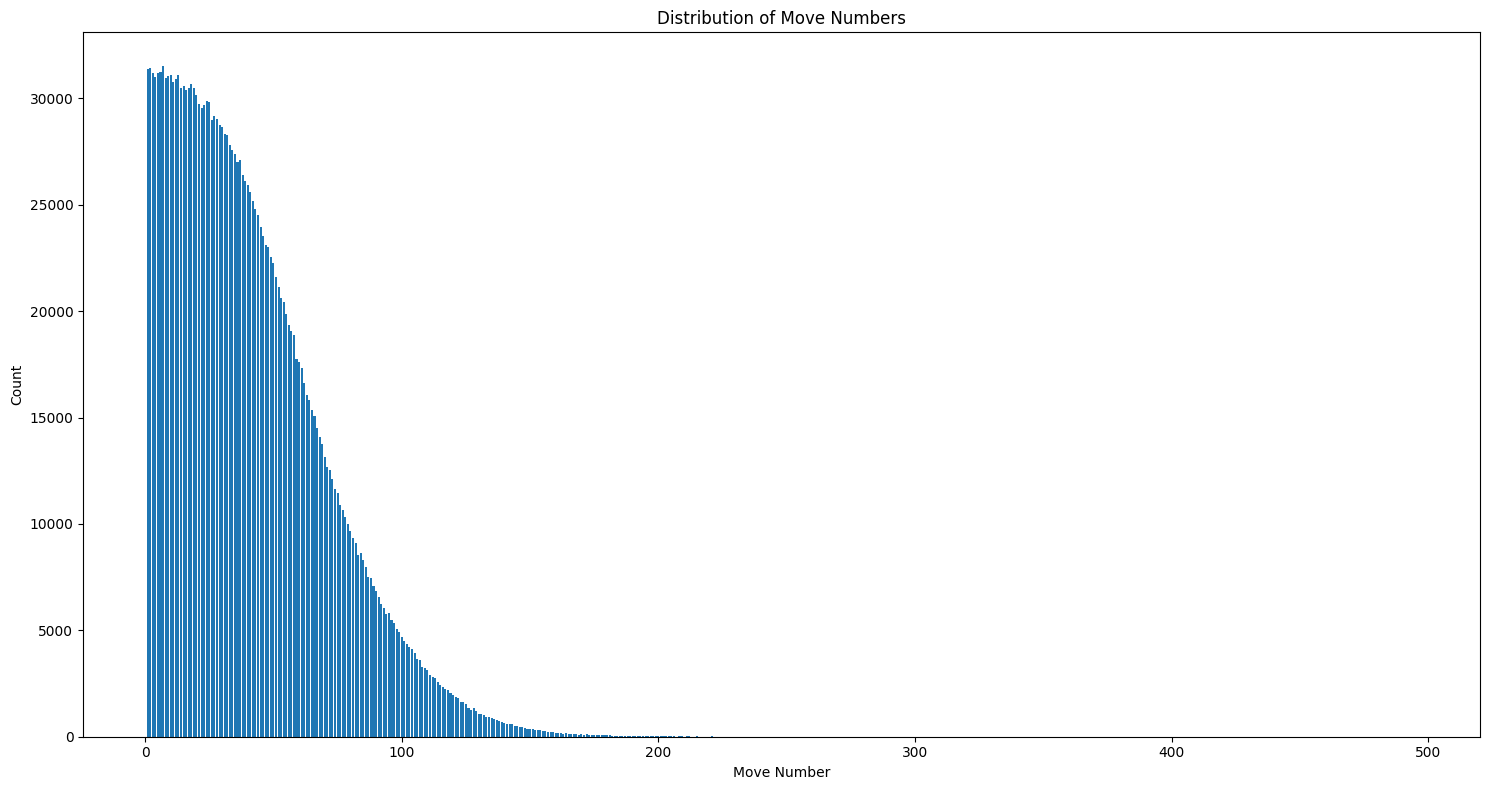


Move number statistics:
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ MoveNumber │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 2.114769e6 │
│ null_count ┆ 0.0        │
│ mean       ┆ 41.257169  │
│ std        ┆ 29.949359  │
│ min        ┆ 1.0        │
│ 25%        ┆ 18.0       │
│ 50%        ┆ 36.0       │
│ 75%        ┆ 59.0       │
│ max        ┆ 495.0      │
└────────────┴────────────┘


In [43]:
# Move number distribution
plt.figure(figsize=(15, 8))

move_counts = (df
    .group_by('MoveNumber')
    .agg(pl.len().alias('count'))
    .sort('MoveNumber')
)

plt.bar(move_counts.select('MoveNumber').to_series(), move_counts.select('count').to_series())
plt.title('Distribution of Move Numbers')
plt.xlabel('Move Number')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Print statistics on move numbers
print("\nMove number statistics:")
print(df.select('MoveNumber').describe())

The distribution of move numbers shows a right-skewed pattern where most chess positions in our dataset occur in the early to middle game (median at move 36), with a peak in the early moves and gradually decreasing frequency as the game progresses. The long tail extends to move 200, but positions beyond move 100 are relatively rare, which is typical of chess game databases and aligns with our goal of opening prediction.


### Position sampling and FEN Visualization

Verifying that boards in the dataset can be visualized


Opening: Sicilian Defense: Closed Variation, Chameleon Variation (ECO: B23
FEN: r2qkbnr/pp2p1pp/2bp1p2/8/2BQP3/2N1B3/PPP2PPP/R3K2R b KQkq - 1 9


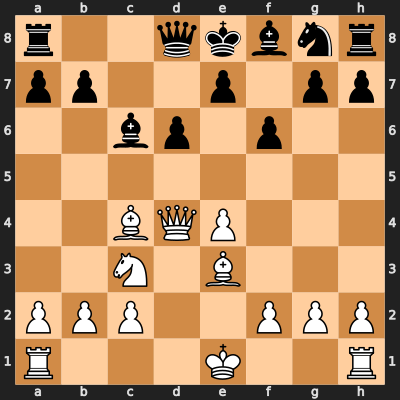


Opening: Bishop's Opening: Boi Variation (ECO: C20
FEN: rnb1k1nr/pppp1pp1/5q1p/8/2B1P3/5N2/PPPP1KPP/RNBQ3R b kq - 2 6


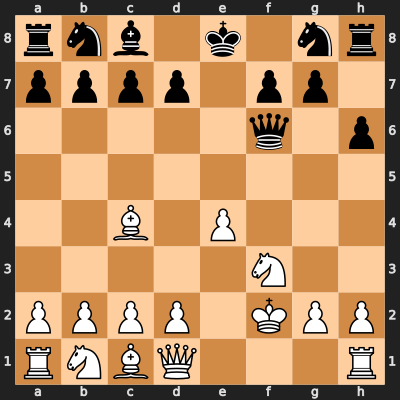


Opening: Queen's Pawn Game: London System (ECO: D02
FEN: 7k/pb6/1p4QB/3p4/7N/2PK1r2/PPB5/r7 w - - 4 32


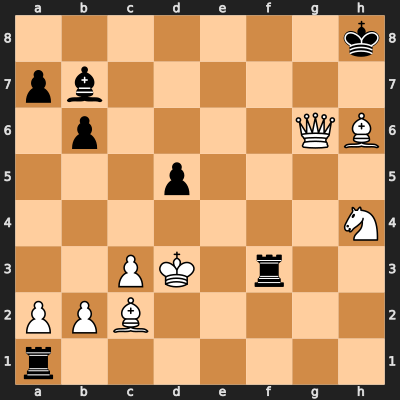

In [44]:
def display_position(fen, title):
    """Display a chess position from FEN string"""
    board = chess.Board(fen)
    svg_board = chess.svg.board(board=board, size=400)
    
    # Display the board
    print(f"\n{title}\nFEN: {fen}")
    display(SVG(svg_board))

# Display sample positions
sample_positions = df.sample(3, seed=0)
for row in sample_positions.iter_rows(named=True):
    display_position(row['Position'], f"Opening: {row['Opening']} (ECO: {row['ECO']}")

## Model Training

In [45]:
#Split the dataset
X = df['Position']
y = df['Opening']

# Create train/val split indices if not already done
n = len(df)
n_train = int(0.6 * n)
n_val = int(0.2 * n)

# Shuffle and split the data
np.random.seed(42)
idx = np.arange(n)
np.random.shuffle(idx)

# Split the data
X_train = X[idx[:n_train]]
X_val = X[idx[n_train:n_train+n_val]]
X_test = X[idx[n_train+n_val:]]

X_train_processed = process_fen(X_train)
X_val_processed = process_fen(X_val)
X_test_processed = process_fen(X_test)

y_train = y[idx[:n_train]]
y_val = y[idx[n_train:n_train+n_val]]
y_test = y[idx[n_train+n_val:]]




### Model 1 - Dense Neural Network

In [46]:
def process_fen(fen_list):
    """Convert FEN strings to one-hot encoded vectors"""
    fen_strings = fen_list.to_numpy() if hasattr(fen_list, 'to_numpy') else fen_list

    vocab = sorted(set('rnbqkpRNBQKP12345678/- '))
    char_to_idx = {char: idx for idx, char in enumerate(vocab)}

    max_length = max(len(fen.split(' ')[0]) for fen in fen_strings)
    num_samples = len(fen_strings)
    vocab_size = len(vocab)

    X = np.zeros((num_samples, max_length, vocab_size), dtype=np.float32)

    for i, fen in enumerate(fen_strings):
        board_part = fen.split(' ')[0]
        for j, char in enumerate(board_part):
            if char in char_to_idx:
                X[i, j, char_to_idx[char]] = 1.0

    return X.reshape(num_samples, -1)  # Flatten for neural network input



In [47]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.device_count())  # Number of GPUs
#print(torch.cuda.get_device_name(0))  # Name of first GPU

print(f'PyTorch version: {torch.__version__}')
print('*'*10)
print(f'_CUDA version: ')
!nvcc --version
print('*'*10)
print(f'CUDNN version: {torch.backends.cudnn.version()}')
print(f'Available GPU devices: {torch.cuda.device_count()}')
print(f'Device Name: {torch.cuda.get_device_name()}')

True
1
PyTorch version: 2.6.0+cu126
**********
_CUDA version: 
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Fri_Jun_14_16:44:19_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.6, V12.6.20
Build cuda_12.6.r12.6/compiler.34431801_0
**********
CUDNN version: 90501
Available GPU devices: 1
Device Name: NVIDIA GeForce RTX 3070


In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import gc

class DenseNNModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_rate=0.2):
        super(DenseNNModel, self).__init__()
        
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, num_classes))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


def train_chess_board_classifier(model, X_train, y_train, X_val, y_val, 
                     learning_rate=0.01, batch_size=4, epochs=50,
                     device='cuda' if torch.cuda.is_available() else 'cpu'):
    
    # Encode labels as integers if needed
    # Fit LabelEncoder on combined data to prevent unseen labels issue
    label_encoder = LabelEncoder()
    label_encoder.fit(np.concatenate([y_train, y_val]))  # Fit on all labels    

    # Transform labels after fitting on both datasets
    y_train = label_encoder.transform(y_train)
    y_val = label_encoder.transform(y_val)

    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.LongTensor(y_val)

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0

    print("\nStarting Training...")
    
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0

        for i in range(0, len(X_train), batch_size):
            batch_X = X_train_tensor[i:i+batch_size].to(device)
            batch_y = y_train_tensor[i:i+batch_size].to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        # Validation phase
        model.eval()
        total_val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for i in range(0, len(X_val), batch_size):
                batch_X = X_val_tensor[i:i+batch_size].to(device)
                batch_y = y_val_tensor[i:i+batch_size].to(device)

                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                total_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()

        avg_train_loss = total_train_loss / (len(X_train) / batch_size)
        avg_val_loss = total_val_loss / (len(X_val) / batch_size)
        val_acc = correct / total

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            print(f"New best validation accuracy: {best_val_acc:.4f}")

        gc.collect()
        if device == 'cuda':
            torch.cuda.empty_cache()

    print(f"\nTraining completed. Best validation accuracy: {best_val_acc:.4f}")
    return history


def plot_history(history):
    """Plot training history"""
    plt.figure(figsize=(12, 4))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()




In [49]:
# Perform processing of our X and y
X = process_fen(df['Position'])
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Opening'])


In [50]:
# Split the data
n = len(df)
n_val = int(n * 0.2)   # 20% validation
n_test = int(n * 0.2)  # 20% test  
n_train = n - n_val - n_test  # remaining 60% train

# Create indices for splits
indices = np.arange(n)
np.random.seed(42)  # for reproducibility
np.random.shuffle(indices)

# Split indices into three parts
train_indices = indices[:n_train]
val_indices = indices[n_train:n_train + n_val]
test_indices = indices[n_train + n_val:]

# Create the actual splits
X_train = X[train_indices]
X_val = X[val_indices]
X_test = X[test_indices]

y_train = y[train_indices]
y_val = y[val_indices]
y_test = y[test_indices]

In [53]:

# Create and train model
input_size = X_train.shape[1]
num_classes = len(label_encoder.classes_)

dropout_rate = 0.2  #Setting dropout to 0
learning_rate = 0.001  #Reduced learning rate to 0.01
inner_layer = [256, 128, 64] #Updated inner layer sizes to double
batch_size = 4096 #Tuned to the amount of cuda cores I have at my disposal
epochs = 500

model = DenseNNModel(
    input_size=input_size,
    hidden_sizes=inner_layer,
    num_classes=num_classes,
    dropout_rate=dropout_rate
)

print("\nTraining Configuration:")
print(f"Dropout Rate: {dropout_rate}, Learning Rate: {learning_rate}, Inner Layer: {inner_layer}, Batch Size: {batch_size}, Epochs: {epochs}")

history = train_chess_board_classifier(
    model=model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    learning_rate=learning_rate,   
    batch_size=batch_size,       
    epochs=epochs             
)

# Save the model
torch.save(model.state_dict(), './models/dense_neural_network_v1.bin')



Training Configuration:
Dropout Rate: 0.2, Learning Rate: 0.001, Inner Layer: [256, 128, 64], Batch Size: 4096, Epochs: 500

Starting Training...
Epoch 1/500 - Train Loss: 6.3360, Val Loss: 6.1253, Val Acc: 0.0316
New best validation accuracy: 0.0316
Epoch 2/500 - Train Loss: 5.9821, Val Loss: 5.7884, Val Acc: 0.0512
New best validation accuracy: 0.0512
Epoch 3/500 - Train Loss: 5.7301, Val Loss: 5.5676, Val Acc: 0.0629
New best validation accuracy: 0.0629
Epoch 4/500 - Train Loss: 5.5658, Val Loss: 5.4158, Val Acc: 0.0739
New best validation accuracy: 0.0739
Epoch 5/500 - Train Loss: 5.4523, Val Loss: 5.3180, Val Acc: 0.0809
New best validation accuracy: 0.0809
Epoch 6/500 - Train Loss: 5.3715, Val Loss: 5.2437, Val Acc: 0.0870
New best validation accuracy: 0.0870
Epoch 7/500 - Train Loss: 5.3095, Val Loss: 5.1864, Val Acc: 0.0918
New best validation accuracy: 0.0918
Epoch 8/500 - Train Loss: 5.2603, Val Loss: 5.1456, Val Acc: 0.0957
New best validation accuracy: 0.0957
Epoch 9/500 -

RuntimeError: Parent directory /models does not exist.

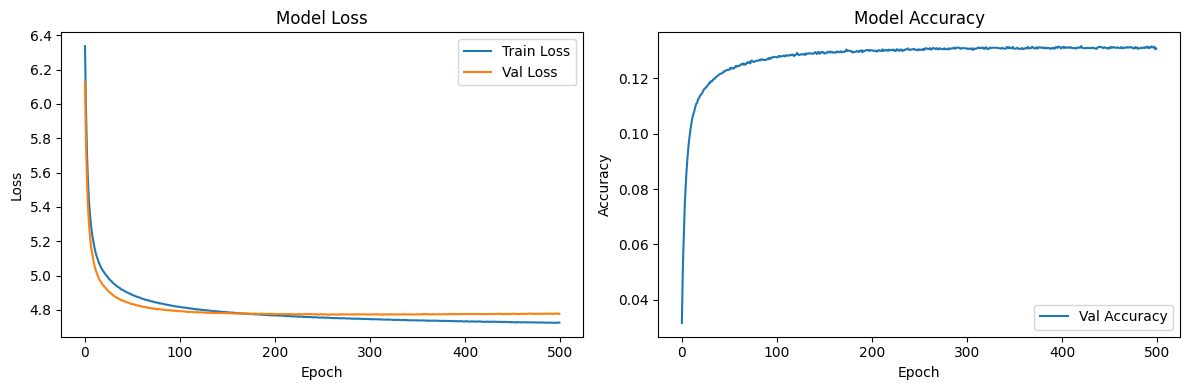

In [55]:
plot_history(history)

We cap at around 13% classification accuracy based for this model, however the loss steadily decreasing suggests that we may be able to improve the model further with tuning. 

### Parameter Tuning for Dense Neural Network

For our following run we will try without dropout, we will also adjust the learning rate and size of the inner layer. 

In [56]:

# Create and train model
input_size = X_train.shape[1]
num_classes = len(label_encoder.classes_)

dropout_rate = 0.0  #Setting dropout to 0
learning_rate = 0.0001  #Reduced learning rate to 0.0001
inner_layer = [512, 256, 128] #Doubled inner layer sizes
batch_size = 4096 
epochs = 500

model_2 = DenseNNModel(
    input_size=input_size,
    hidden_sizes=inner_layer,
    num_classes=num_classes,
    dropout_rate=dropout_rate
)

print("\nTraining Configuration:")
print("Dropout Rate: {dropout_rate}, Learning Rate: {learning_rate}, Inner Layer: {inner_layer}, Batch Size: {batch_size}, Epochs: {epochs}")

history_2 = train_chess_board_classifier(
    model=model_2,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    learning_rate=learning_rate,   
    batch_size=batch_size,       
    epochs=epochs             
)

# Save the model
torch.save(model_2.state_dict(), './models/dense_neural_network_v2.bin')


Training Configuration:
Dropout Rate: {dropout_rate}, Learning Rate: {learning_rate}, Inner Layer: {inner_layer}, Batch Size: {batch_size}, Epochs: {epochs}

Starting Training...
Epoch 1/500 - Train Loss: 6.5683, Val Loss: 6.2219, Val Acc: 0.0230
New best validation accuracy: 0.0230
Epoch 2/500 - Train Loss: 6.1728, Val Loss: 6.2040, Val Acc: 0.0300
New best validation accuracy: 0.0300


KeyboardInterrupt: 

In [ ]:
# Plot the results
plot_history(history_2)